In [11]:
import numpy as np

from models.CM1DLayers import IlluminationLayer, ZNCCLayer
from dataset.dataset import SampleLabels
from utils.torch_utils import *
from felipe_utils.research_utils.signalproc_ops import gaussian_pulse

import matplotlib.pyplot as plt
import matplotlib

In [12]:

rep_freq = 5 * 1e6
rep_tau = 1. / rep_freq
sigma = 10

photon_count = 200
sbr = 1.0
n_tbins = 200
k = 4

In [19]:
inits = ['TruncatedFourier', 'experiments/illum_models/version_7/checkpoints/coded_model.ckpt', 'experiments/illum_models/version_8/checkpoints/coded_model.ckpt', 
         'experiments/illum_models/version_10/checkpoints/coded_model.ckpt', 'experiments/illum_models/version_12/checkpoints/coded_model.ckpt']

In [20]:
sample_data = SampleLabels(n_tbins, num_samples=10000)
num_samples = len(sample_data)
labels = sample_data.labels

gt_depths = bin2depth(labels, num_bins=n_tbins, tau=rep_tau)


hirf is NONE
t_domain is None
Fourier coding K=4
MAE TruncatedFourier: 963.510 mm 
MAE coded_model: 1078.890 mm 
MAE coded_model: 3063.585 mm 
MAE coded_model: 1641.945 mm 
MAE coded_model: 1721.220 mm 


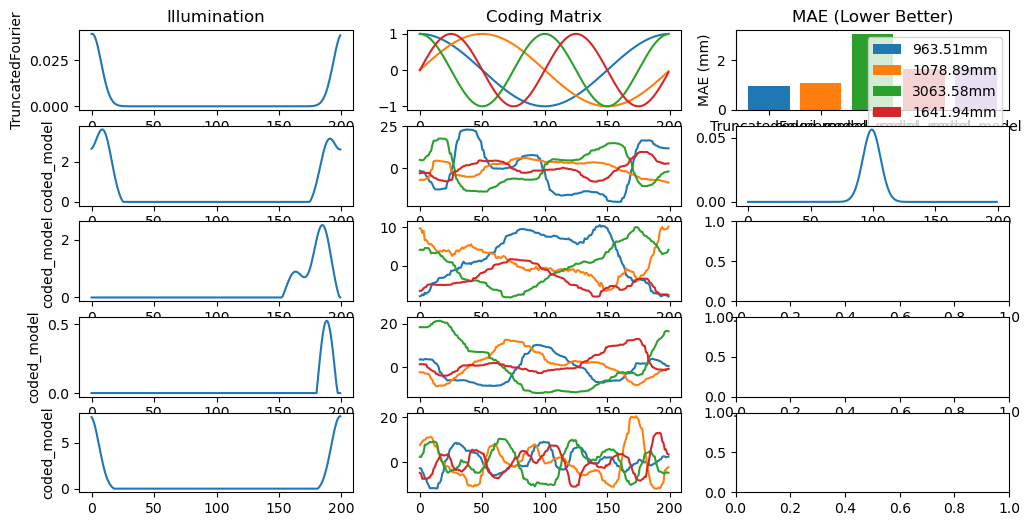

In [21]:
fig, axs = plt.subplots(len(inits), 3, figsize=(12, 6))
counter = 0
names = []
for init in inits:
    if init.endswith('.ckpt'): get_from_model = True
    else: get_from_model = False

    model = IlluminationLayer(k=k, n_tbins=n_tbins, init=init, sigma=sigma, get_from_model=get_from_model)

    zncc_layer = ZNCCLayer()

    c_vals = model(labels, photon_count, sbr)

    pred_depths = zncc_layer(c_vals, model.cmat1D.weight.data.detach().clone())

    pred_depths = bin2depth(pred_depths, num_bins=n_tbins, tau=rep_tau)
    
    loss = torch.mean(torch.abs(pred_depths.squeeze() - gt_depths.squeeze()))
    #loss = criterion_RMSE(pred_depths, gt_depths)

    print(f'MAE {init.split('/')[-1].split('.')[0]}: {loss * 1000:.3f} mm ')
    names.append(init.split('/')[-1].split('.')[0])
    cmat = model.cmat1D.weight
    cmat = np.transpose(cmat.detach().numpy().squeeze())

    illum = model.irf_layer(model.illumination.view(1, n_tbins)).view(n_tbins, 1).numpy().squeeze()
    illum[illum < 0] = 0
    axs[counter][0].plot(illum)
    axs[counter][0].set_ylabel(init.split('/')[-1].split('.')[0])
    axs[counter][1].plot(cmat)
    
    #axs[counter][1].set_title(init.split('/')[-1].split('.')[0])

    axs[0][2].bar(counter, loss, label=f'{loss * 1000:.2f}mm')
    axs[0][2].set_title('MAE (Lower Better)')
    axs[0][2].set_ylabel('MAE (mm)')


    axs[0][1].set_title('Coding Matrix')
    axs[0][0].set_title('Illumination')


    counter += 1

axs[0][2].set_xticks(np.arange(0, len(inits)))
axs[0][2].set_xticklabels(names)
axs[0][2].legend()

pulse_domain = np.arange(0, n_tbins)
pulse = gaussian_pulse(pulse_domain, mu=pulse_domain[-1] // 2, width=sigma, circ_shifted=True)

axs[1][2].plot(pulse.squeeze())

plt.show(block=True)
